<table>
  <tr>
    <td><p style="font-size:45px; color: #55BBD2">Analysis of light microscopy images in Python</p></td>
    <td><img src="../ressources/lmb_logo.svg" alt="LMB Logo" width="500" height="600" align="right"></td>
  </tr>
</table>
<table>
  <tr>
    <td><p style="font-size:15px; color: #55BBD2">Version: September 2025</p></td>
  </tr>
</table>

# Part 2: Measurement in a region of interest (ROI)

<b>Problem:</b> Count the number of peroxisome in a cell

<b>Dataset:</b> airyscan-4colors.tif

![title](../ressources/data1.png)

<b>Credit:</b> Ulrike Schulze

<b>Objectives:</b>
- Filter an image (skimage.filters.gaussian, skimage.filters.median)
- Segment an image using a simple thresholding (comparison operators >=, skimage.filters.threshold_otsu)
- Visualize segmentation results (skimage.measure.find_contours)
- Post process binary masks (skimage.morphology.remove_small_objects, skimage.morphology.closing, morphology.footprint_rectangle, skimage.segmentation.clear_border, skimage.color.label2rgb, scipy.ndimage.binary_fill_holes)
- Segment overlapping objects using a watershed-based segmentation (scipy.ndimage.distance_transform_edt, skimage.segmentation.watershed)
- Convert the bit depth of an image (numpy.ndarray.astype)
- Detect spots and generate an image of spot labels from the coordinates (skimage.feature.blob_dog, skimage.util.label_points)
- Measure information within a given ROI (skimage.measure.regionprops_table)
- Use object parenting to count spots per cell (the def keyword)
- Manipulate and structure tabular data (pandas.DataFrame, pandas.merge, pandas.DataFrame.to_csv)

<b>Workflow:</b>

<img src="../ressources/workflow/workflow1.png" alt="drawing" width="800"/>

In [1]:
from pathlib import Path
from bioio import BioImage

data_folder = Path('../data')
image = BioImage(data_folder /'airyscan-4colors.tif')

data = image.data

## Image filtering and noise
Filtering is a technique for modifying or enhancing an image. We can filter an image to emphasize certain features or remove other features. Noise filtering is an example of image filtering.

Noise in microscopic image is unavoidable during image acquisition. Dominant noise in fluorescence microscopy follows either a Gaussian distribution or Poisson distribution or both but mostly both. Gaussian noise is additive while Poisson noise is signal dependent. A correct removal of those two different types of noise may therefore differ. Firstly, we will look at how those noise affect the image differently. 

### Noise filtering

There are different types of noise reduction such as smoothing filtering or convolution filtering, median filtering, or frequency filtering. 

As each pixel has a value which represents the image intensity at the spatial position of the pixel, we need to work on each pixel of the image to filter an image.

### Gaussian filter
A smoothing filter can use the principle of convolution to reduce the noise. The process is similar to drawing where the kernel is the pencil. The sharpness of the drawn image depends on the width of the point of the pencil. In the case of a Gaussian filtering, the Gaussian distribution is used as a kernel. When used for noise filtering, the noise, which should have a lower intensity value than the real signal, gets smoothed out because of this convolution process.

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


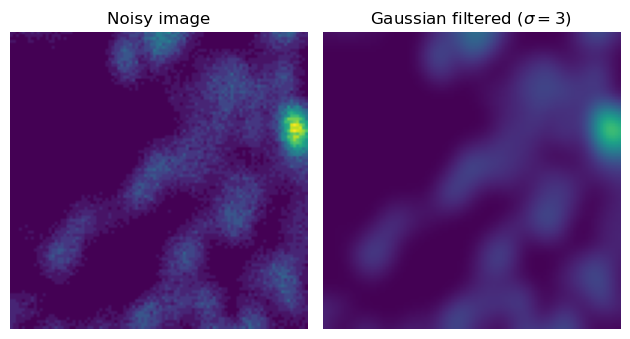

In [2]:
from skimage import filters
import matplotlib.pyplot as plt

# Crop the image and select the first channel
crop = image.data[0, 0, 0, 850:950, 900:1000]

# Gaussian filtering of data with a Gaussian filter of a given sigma
sigma = 3
gaussian_filtered = filters.gaussian(crop.astype(float), sigma)

fig, axs = plt.subplots(1, 2)
vmin, vmax = crop.min(), crop.max()

axs[0].imshow(crop, vmin = vmin, vmax = vmax)                      # original image
axs[0].set_title('Noisy image')
axs[0].set_axis_off()

axs[1].imshow(gaussian_filtered, vmin = vmin, vmax = vmax)                # Gaussian filtered
axs[1].set_title(r'Gaussian filtered ($\sigma=$'+str(sigma)+')')
axs[1].set_axis_off()

plt.tight_layout()

<div class="alert alert-success">
       
#### Exercise 

In the previous cell, change the standard deviation sigma of the Gaussian kernel and observe the change in the Gaussian filtered image.
    
</div>

### Median filter

Median filtering is a different noise filtering technique. With the median filter, each output pixel is computed as the median value of the input pixel under a chosen window called footprint. 

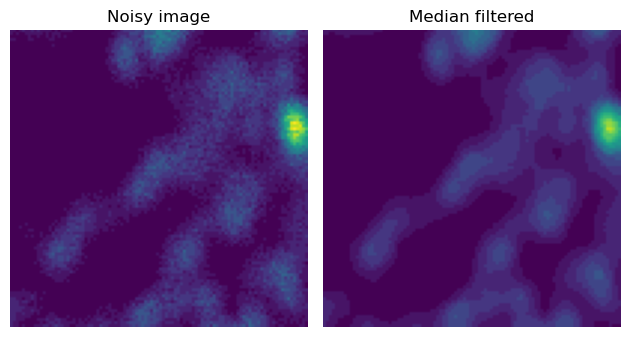

In [3]:
from skimage import filters
import numpy as np

# define the footprint
footprint = np.ones((5,5)) 

# the footprint is introduced in the second argument of the function 
median_filtered = filters.median(crop, footprint) 

fig, axs = plt.subplots(1, 2)

# compute the min and max of the original image to keep the same display range
vmin, vmax = crop.min(), crop.max()

axs[0].imshow(crop, vmin = vmin, vmax = vmax)    
axs[0].set_title('Noisy image')
axs[0].set_axis_off()

axs[1].imshow(median_filtered,  vmin = vmin, vmax = vmax)    
axs[1].set_title('Median filtered')
axs[1].set_axis_off()

plt.tight_layout()

<div class="alert alert-success">

#### Exercise       

Change the size of the footprint and observe the change in the median filtered image.
    
</div>

## Segmentation

Image segmentation is the process of partitioning an image into multiple distinct regions. In semantic segmentation, regions can represent objects of interests against background. They can then be represented as a binary mask. Several type of objects can be further encoded using a label image. Finally, instance segmentation aims at distinguishing different identities of objects of potentially the same class and can also be represented using a label image.

To segment, we need to find the masks which represent each region of interest (ROI). This can easily be done by simply thresholding the intensity of the image. By this, the mask is defined such that only intensity (pixel) values greater than the threshold are selected. If we stop at this stage, we may encounter a problem such that some values within the thresholded region may get discarded because the intensity value is lower than the threshold and the ROI won't be filled. In this case, we may need to find the edge or/and fill the mask region. Another issue that we may encounter is that the edges of the regions may overlap so they may be detected or segmented as one. One solution in this case is to use what is called watershed segmentation. This technique helps to detect the flow of the intensity and decide from there whether the regions form only one object or different objects. 

### Thresholding 

The simplest way of doing this is to use a manually selected threshold, where an intensity value is defined as a threshold.

(-0.5, 1911.5, 1911.5, -0.5)

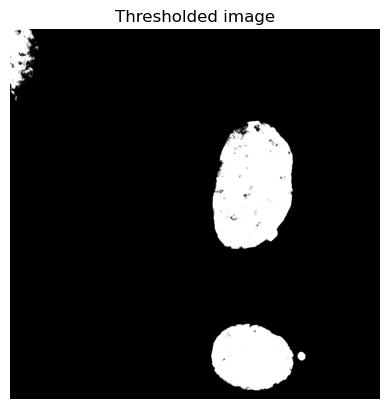

In [4]:
from skimage import filters
import matplotlib.pyplot as plt


nuclei = image.data[0,3,0,:,:] # the object we want to segment and set as markers of our final ROI

threshold = 6  # change threshold value here to see what happens to the mask that is being displayed below
mask = nuclei >= threshold  

plt.imshow(mask, cmap='gray')
plt.title('Thresholded image')
plt.axis('off')

Lets plot the contour of this mask over the image to judge the quality of the segmentation.

Text(0.5, 1.0, 'Contours of the segmented image')

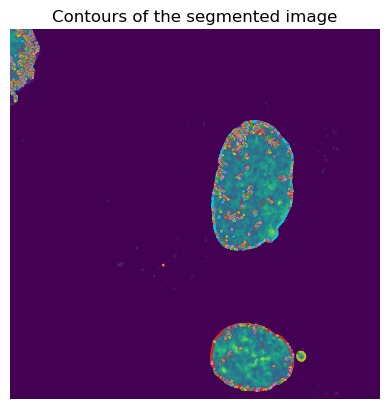

In [5]:
from skimage import measure

contours = measure.find_contours(mask)

plt.imshow(nuclei)
# For each elements of the contours
for contour in contours:
    plt.plot(contour[:,1], contour[:,0])

plt.axis('off')
plt.title('Contours of the segmented image')

<div class="alert alert-success">

#### Exercise       

You should notice that many countours are formed. This is because we generate the mask from the raw data. It is often a good practice to apply an appropriate filtering to the data before segmentation. Hence, apply a Gaussian filter of a given sigma to the nuclei data while avoiding any scaling in the data during the filtering process by setting preserve_range=True as an argument to the function. Secondly, generate the mask by segmenting the filtered nuclei data. 

Hint: nuclei_flt = filters.gaussian(nuclei, 6, preserve_range=True) 
    
</div>

### Automated thresholding segmentation 

If a single threshold is not suitable for a collection of images, a thresholding algorithm can be used. One example of this is Otsu's method [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method). More thresholding algorithms can be found in the [skimage.filters package](https://scikit-image.org/docs/stable/api/skimage.filters.html). 

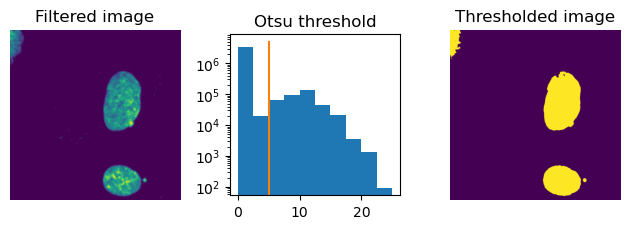

In [6]:
from skimage import filters

# filter the nuclei with a sigma 5
nuclei_flt = filters.gaussian(nuclei, 5, preserve_range=True)

# find the threshold value differentiating the signal from background
threshold = filters.threshold_otsu(nuclei_flt) 

# define the threshold mask and close it
nuclei_mask = nuclei_flt > threshold

fig, ax = plt.subplots(1,3)

ax[0].imshow(nuclei_flt)
ax[0].set_title('Filtered image')
ax[0].set_axis_off()

ax[1].hist(nuclei.ravel(),log=True)
ax[1].plot([threshold, threshold], [0,5e6])
ax[1].set_title('Otsu threshold')
ax[1].set_aspect(5)

ax[2].imshow(nuclei_mask)
ax[2].set_title('Thresholded image')
ax[2].set_axis_off()

plt.tight_layout()

### Post processing of binary masks
The mask obtained after thresholding can be further processed using morphological operations.

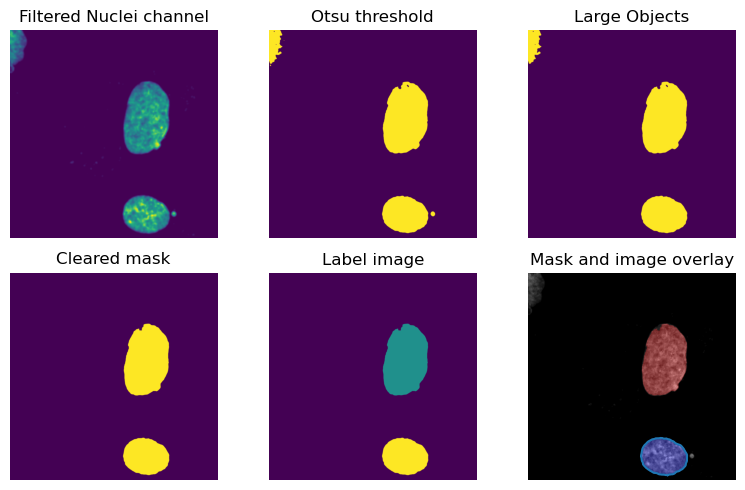

In [7]:
from skimage import morphology
from skimage import segmentation
from skimage import measure
from skimage import color

# remove artifacts connected to image border
only_large_objects = morphology.remove_small_objects(nuclei_mask, 10000)
cleared = morphology.closing(only_large_objects, morphology.footprint_rectangle((20, 20)))
cleared = segmentation.clear_border(cleared)

# label image regions
nuclei_label = measure.label(cleared)

# label image to rgb 
nuclei_label_overlay = color.label2rgb(nuclei_label, image=10*nuclei, bg_label=0)

fig, ax = plt.subplots(2, 3, figsize=(8,5))

ax[0,0].imshow(nuclei_flt)
ax[0,0].set_title('Filtered Nuclei channel')
ax[0,0].set_axis_off()


ax[0,1].imshow(nuclei_mask)
ax[0,1].set_title('Otsu threshold')
ax[0,1].set_axis_off()

ax[0,2].imshow(only_large_objects)
ax[0,2].set_title('Large Objects')
ax[0,2].set_axis_off()

ax[1,0].imshow(cleared)
ax[1,0].set_title('Cleared mask')
ax[1,0].set_axis_off()

ax[1,1].imshow(nuclei_label)
ax[1,1].set_title('Label image')
ax[1,1].set_axis_off()

ax[1,2].imshow(nuclei_label_overlay)
ax[1,2].set_title('Mask and image overlay')
ax[1,2].set_axis_off()

contours = measure.find_contours(nuclei_label)
for contour in contours:
    plt.plot(contour[:,1], contour[:,0])

plt.tight_layout()

### Watershed-based segmentation
The segmentation of the nuclei is pretty straightforward because they are well separated. In some cases however, the objects we want to segment overlap, making it difficult to discern the different regions. In this case, we would need to add extra step into the image segmentation in order to discern the objects. Watershed segmentation is useful for this purpose. It is generally used for separating different objects. Watershed algorithm treats pixels values as a local topography (elevation) so the goal is to follow the flow of the elevation and find the watershed lines from which the edge of each of the regions are deduced. We use this principle to extract our previously defined ROIs: the actin region in Channel-1 having the two nuclei as markers and the seeds of the segmentation. 

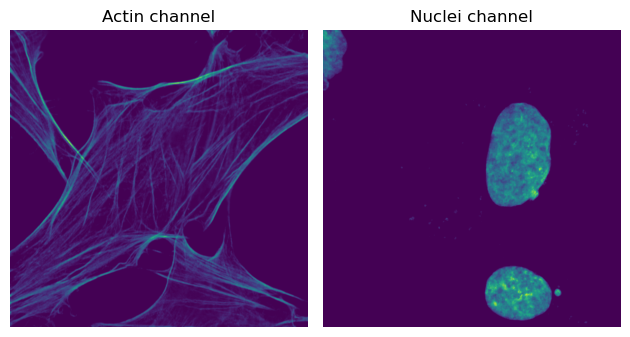

In [8]:
actin  = image.data[0,1,0,:,:] #  the channel we want to segment 

fig, axs = plt.subplots(1,2)
axs[0].imshow(actin)
axs[0].set_title('Actin channel')
axs[0].set_axis_off()

axs[1].imshow(nuclei)
axs[1].set_title('Nuclei channel')
axs[1].set_axis_off()

plt.tight_layout()

#### Mask in the actin channel
Create a mask on the actin using thresholding and morphological operations for closing and filling the mask. In the morphological operations, the erosion and dilation operations are used: <br>
- Erosion: removes small objects so only the big objects will remain in the image,
- Dilation: makes small objects more visible and fills in small holes in objects,
- Closing: a successive operation of those two operations dilation followed by an erosion.

In the following cell, we will first segment the actin channel.

(min, max) of the dynamic range of smooth_actin = (1.6373227574781546e-06, 6.925380267500556)
optimal threshold: 2.3941266715834413


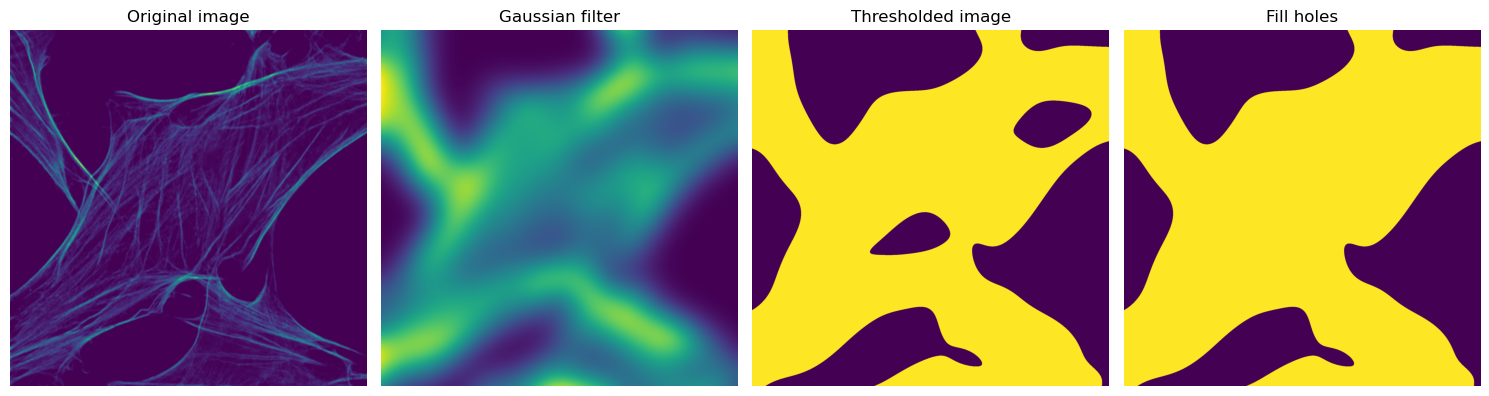

In [9]:
from scipy import ndimage as ndi
from skimage import filters

# smoothed the image using the Gaussian filter of a given sigma
smooth_actin = filters.gaussian(actin, sigma=90, preserve_range=True)
print('(min, max) of the dynamic range of smooth_actin =', (np.min(smooth_actin), np.max(smooth_actin)))

# find the optimal threshold
threshold = filters.threshold_otsu(smooth_actin)
print("optimal threshold:", threshold)

# define the threshold mask
thresh_mask = smooth_actin > threshold

# fill holes to form the the actin_mask without performing the closing function
actin_mask = ndi.binary_fill_holes(thresh_mask).astype(int)

fig, axs = plt.subplots(1,4, figsize=(15, 15))
axs[0].imshow(actin)
axs[0].set_title('Original image')
axs[0].set_axis_off()

axs[1].imshow(smooth_actin)
axs[1].set_title('Gaussian filter')
axs[1].set_axis_off()

axs[2].imshow(thresh_mask)
axs[2].set_title('Thresholded image')
axs[2].set_axis_off()

axs[3].imshow(actin_mask)
axs[3].set_title('Fill holes')
axs[3].set_axis_off()

plt.tight_layout()

<div class="alert alert-success">

#### Exercise       

In the previous cell, play with the sigma value of the filters.gaussian to observe the effect on the segmentation.
    
</div>

#### Distance transform and watershed
The next step will consists of computing the distance transform of the actin mask. Observe how the value of the distance inside the regions change with the spatial coordinates. 

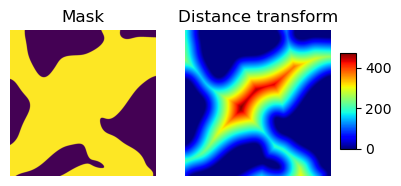

In [10]:
from scipy import ndimage as ndi
distance = ndi.distance_transform_edt(actin_mask) 

fig, ax = plt.subplots(1,3)

ax[0].imshow(actin_mask)
ax[0].set_title('Mask')
ax[0].set_axis_off()

im = ax[1].imshow(distance, cmap='jet')
ax[1].set_title('Distance transform')
ax[1].set_axis_off()

# insert the colorbar 
ax[2].set_position([0.64,0.4,0.025,0.2])
fig.colorbar(im, cax=ax[2])

Now we set the nuclei we segmented before as the markers or seeds of the segmentations. We use the markers to label the segmented regions in the actin region. 
After, we watershed the negative inverse of the distance transform of the actin using the defined markers and within the mask delimited by the actin. The negative inverse of the distance is used in the watershed function instead of the distance because the goal is to have the objects region as valleys not peak.  

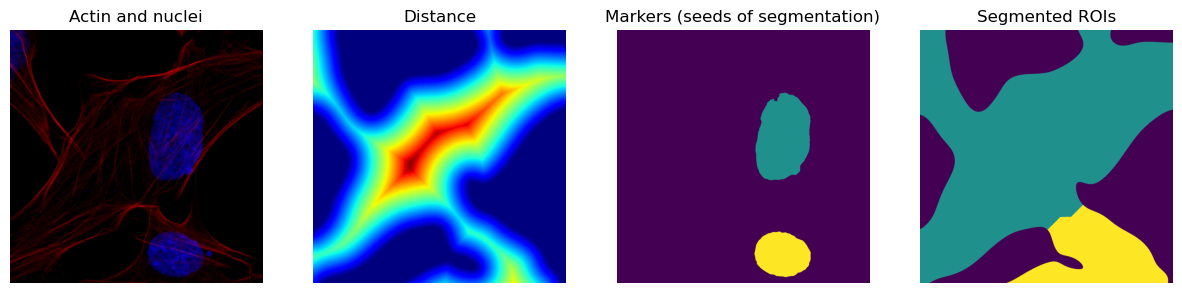

In [11]:
from skimage import segmentation

cell_label = segmentation.watershed(-distance, markers = nuclei_label, mask = actin_mask)

fig, ax = plt.subplots(1,4, figsize=(15, 15))

# create a RGB composite image to display the two channels (normalize channel in between 0 and 1)
rgb = np.stack([actin.astype(float) / actin.max(), 
                np.zeros(actin.shape), 
                nuclei.astype(float) / nuclei.max()], axis=2)

ax[0].imshow(rgb)
ax[0].set_axis_off()
ax[0].set_title('Actin and nuclei')

ax[1].imshow(distance, cmap='jet')
ax[1].set_title('Distance')
ax[1].set_axis_off()

ax[2].imshow(nuclei_label)
ax[2].set_title('Markers (seeds of segmentation)')
ax[2].set_axis_off()

ax[3].imshow(cell_label)
ax[3].set_title('Segmented ROIs')
ax[3].set_axis_off()

## Region properties

To measure information within the ROI masks that we have previously segmented, we use the regionprops function. It allows us to define a list of geometrical and intensity properties which can be measured in the images. 

This is a selection of useful properties supported by regionprops:
  - area
  - bbox
  - bbox_area
  - centroid
  - coords
  - equivalent_diameter
  - label
  - major_axis_length
  - max_intensity
  - mean_intensity
  - min_intensity
  - minor_axis_length
  - slice
  - solidity
  - eccentricity
  - orientation
  - perimeter

### Maximum Intensity

In [12]:
import pandas as pd
from skimage import measure


peroxisome = image.data[0, 2, 0, :, :]

max_intensity_table = measure.regionprops_table(cell_label, peroxisome, properties=('label', 'intensity_max'))
max_intensity_dataframe = pd.DataFrame(max_intensity_table)

max_intensity_dataframe

,label,intensity_max
0,1,68.0
1,2,3.0


In [13]:
import pandas as pd
from skimage import measure

peroxisome = image.data[0, 2, 0, :, :]

peroxisome_props = measure.regionprops(cell_label, peroxisome)
actin_props = measure.regionprops(cell_label, actin)

# Get the list of labels from the regions properties
labels = [p.label for p in peroxisome_props]

# Get the maximum intensity for the properties
peroxisome_max_intensity = [p.intensity_max for p in peroxisome_props]
actin_max_intensity = [p.intensity_max for p in actin_props]

# Gather the results in a data frame (table)
max_intensity_dataframe = pd.DataFrame({
    'Region label': labels, 
    'Peroxisome [ch2] maximum intensity': peroxisome_max_intensity,
    'Actin [ch1] maximum intensity': actin_max_intensity})

max_intensity_dataframe

,Region label,Peroxisome [ch2] maximum intensity,Actin [ch1] maximum intensity
0,1,68.0,49.0
1,2,3.0,33.0


### Defining a custom measurement to count the number of peroxisome spots per cell

A custom function needs to be defined to count the number of peroxisome spots for each cell ROI as the regionprops function cannot directly do it. To do achieve this goal, we can follow the following steps:

1. Detect the spots using the blob_dog spot detector
2. Convert the spots coordinates into a label point image
3. Define a function that counts the spots labels per ROI
4. Add the custom function into the extra_properties of regionprops_table
5. Convert the result into a pandas dataframe
6. Merge the dataframe with the previous table of maximal intensity
7. Inspect final result by visualizing the different steps in napari
8. Save the final result in a csv file

The Laplacian of Gaussian (LoG) is an accurate but slower approach for spot detection in skimage. We will cover three important parameters here:

- min_sigma: the minimum standard deviation for Gaussian kernel.
- max_sigma: the maximum standard deviation for Gaussian kernel.
- threshold: the absolute lower bound for scale space maxima. Local maxima smaller than threshold are ignored.

Further reading: https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.blob_log

In [14]:
from skimage import feature

blobs = feature.blob_log(peroxisome, min_sigma=2, max_sigma=10, threshold=0.01)

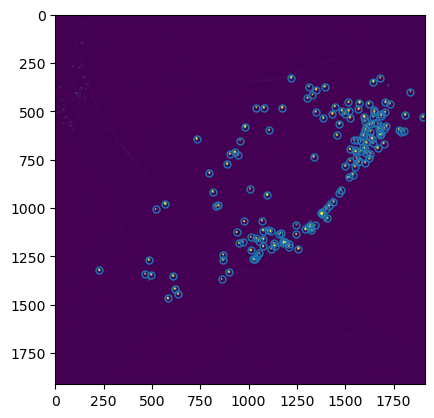

In [15]:
plt.imshow(peroxisome, vmax=peroxisome.max()/10)
plt.plot(blobs[:,1], blobs[:,0], 'o', ms=5, fillstyle='none')

In [16]:
from skimage.util import label_points

peroxisome_label = label_points(blobs[:, 0:2], peroxisome.shape)

In [17]:
def count_spots(mask, spot_label):
    '''Count the number of spots in a mask

    Parameters
    ----------
    mask : binary image
    spot_label: image labelled with the spot ids

    Returns
    -------
    number of spots per mask
    '''
    count = len(np.unique(spot_label[mask])) - 1 # -1 because the label 0 is reserved for the backgroun
    return count

number_peroxisome = measure.regionprops_table(cell_label, peroxisome_label, 
                                 properties = ('label',), 
                                 extra_properties = (count_spots,))

number_peroxisome_dataframe = pd.DataFrame(number_peroxisome)

# rename the 'label' column to 'Region label'
number_peroxisome_dataframe = number_peroxisome_dataframe.rename(columns={"label": 'Region label'})

number_peroxisome_dataframe

,Region label,count_spots
0,1,153
1,2,0


Merge the two dataframe number_peroxisome_dataframe and max_intensity_dataframe

In [18]:
results = pd.merge(max_intensity_dataframe, number_peroxisome_dataframe, how='outer', on='Region label')
results

,Region label,Peroxisome [ch2] maximum intensity,Actin [ch1] maximum intensity,count_spots
0,1,68.0,49.0,153
1,2,3.0,33.0,0


## Visualize in napari

<div class="alert alert-success">
       
#### Exercise 

Display in different napari layers the following:

1. the raw data with channel_names = ['mitochondria', 'actin', 'peroxisome', 'nuclei'] and appropriate contrast_limits
2. the cell_label in a label layer
3. the points generated in the 'blobs' variable with opacity equal to 0.5
4. the peroxisome_label as an image layer with a 'green' colormap and 'additive' blending 

</div>

## Save result
Export the result stored in the panda dataframe into a csv file

In [19]:
results.to_csv('peroxisome_count.csv')